In [ ]:
from supabase import create_client, Client
import pandas as pd
from dotenv import load_dotenv
import os

load_dotenv()

SUPABASE_URL = os.getenv("SUPABASE_URL")
SUPABASE_KEY = os.getenv("SUPABASE_KEY")

supabase: Client = create_client(SUPABASE_URL, SUPABASE_KEY)

participants_data = supabase.table("participants").select("*").execute()
print("Participants Data:", participants_data.data)

responses_data = supabase.table("responses").select("*").execute()
print("Responses Data:", responses_data.data)

participants_df = pd.DataFrame(participants_data.data)
participants_df.to_csv("participants.csv", index=False)

responses_df = pd.DataFrame(responses_data.data)
responses_df.to_csv("responses.csv", index=False)

merged_df = responses_df.merge(participants_df, left_on='participant_id', right_on='id')
merged_df.to_csv("merged_participants_responses.csv", index=False)


ConnectError: [Errno 8] nodename nor servname provided, or not known

In [ ]:
def parse_clip_info(clip_path):
    parts = clip_path.split("/")
    model = parts[1]  # Matcha or Toucan
    dialect = parts[2]  # Trondelag or Vestland
    return model, dialect

merged_df[['clip_a_model', 'clip_a_dialect']] = merged_df['clip_a_id'].apply(lambda x: pd.Series(parse_clip_info(x)))
merged_df[['clip_b_model', 'clip_b_dialect']] = merged_df['clip_b_id'].apply(lambda x: pd.Series(parse_clip_info(x)))

merged_df['preferred_model'] = merged_df.apply(
    lambda row: row['clip_a_model'] if row['preference'] == 'A' else (
        row['clip_b_model'] if row['preference'] == 'B' else 'No Preference'
    ), axis=1
)

merged_df.to_csv("scores_with_models.csv", index=False)

In [ ]:
# Find the number of participants who preferred each model
# and calculate the percentage of each preference

preference_counts = merged_df['preferred_model'].value_counts()

preference_percentages = (preference_counts / len(merged_df)) * 100

preference_stats = pd.DataFrame({
    'Count': preference_counts,
    'Percentage': preference_percentages
}).reset_index()

preference_stats.rename(columns={'index': 'Model'}, inplace=True)

print("Preference Statistics:")
print(preference_stats)

preference_stats.to_csv("preference_statistics.csv", index=False)


Preference Statistics:
  preferred_model  Count  Percentage
0          Toucan    306   70.506912
1   No Preference     70   16.129032
2          Matcha     58   13.364055


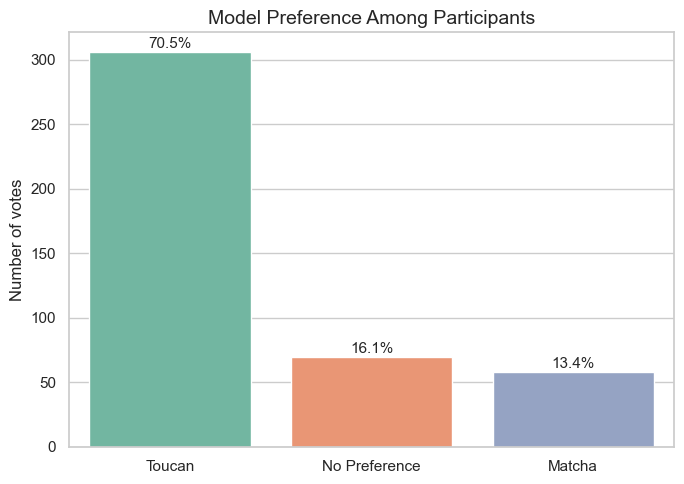

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

# Set style
sns.set_theme(style="whitegrid")

plt.figure(figsize=(7, 5))
ax = sns.barplot(data=preference_stats, x='preferred_model', y='Count', palette='Set2')

for i, row in preference_stats.iterrows():
    ax.text(
        i, row['Count'] + 0.5,
        f"{row['Percentage']:.1f}%",
        ha='center', va='bottom', fontsize=11
    )

plt.title("Model Preference Among Participants", fontsize=14)
plt.ylabel("Number of votes")
plt.xlabel("")
plt.tight_layout()
plt.savefig("model_preference_barplot.pdf", format="pdf")
plt.show()


In [ ]:
# Finds the average scores for each model based on the three metrics (authenticity, naturalness, intelligibility)

merged_df['authenticity_matcha'] = merged_df.apply(
    lambda row: row['authenticity_a'] if row['clip_a_model'] == 'Matcha' else row['authenticity_b'], axis=1
)
merged_df['authenticity_toucan'] = merged_df.apply(
    lambda row: row['authenticity_a'] if row['clip_a_model'] == 'Toucan' else row['authenticity_b'], axis=1
)

merged_df['naturalness_matcha'] = merged_df.apply(
    lambda row: row['naturalness_a'] if row['clip_a_model'] == 'Matcha' else row['naturalness_b'], axis=1
)
merged_df['naturalness_toucan'] = merged_df.apply(
    lambda row: row['naturalness_a'] if row['clip_a_model'] == 'Toucan' else row['naturalness_b'], axis=1
)

merged_df['intelligibility_matcha'] = merged_df.apply(
    lambda row: row['intelligibility_a'] if row['clip_a_model'] == 'Matcha' else row['intelligibility_b'], axis=1
)
merged_df['intelligibility_toucan'] = merged_df.apply(
    lambda row: row['intelligibility_a'] if row['clip_a_model'] == 'Toucan' else row['intelligibility_b'], axis=1
)

average_scores = {
    'authenticity': {
        'matcha': merged_df['authenticity_matcha'].mean(),
        'toucan': merged_df['authenticity_toucan'].mean()
    },
    'naturalness': {
        'matcha': merged_df['naturalness_matcha'].mean(),
        'toucan': merged_df['naturalness_toucan'].mean()
    },
    'intelligibility': {
        'matcha': merged_df['intelligibility_matcha'].mean(),
        'toucan': merged_df['intelligibility_toucan'].mean()
    }
}

print("Average Scores:")
print(pd.DataFrame(average_scores))
merged_df.to_csv("scores_with_models.csv", index=False)


Average Scores:
        authenticity  naturalness  intelligibility
matcha      2.082949     1.900922         2.126728
toucan      3.391705     3.414747         3.117512


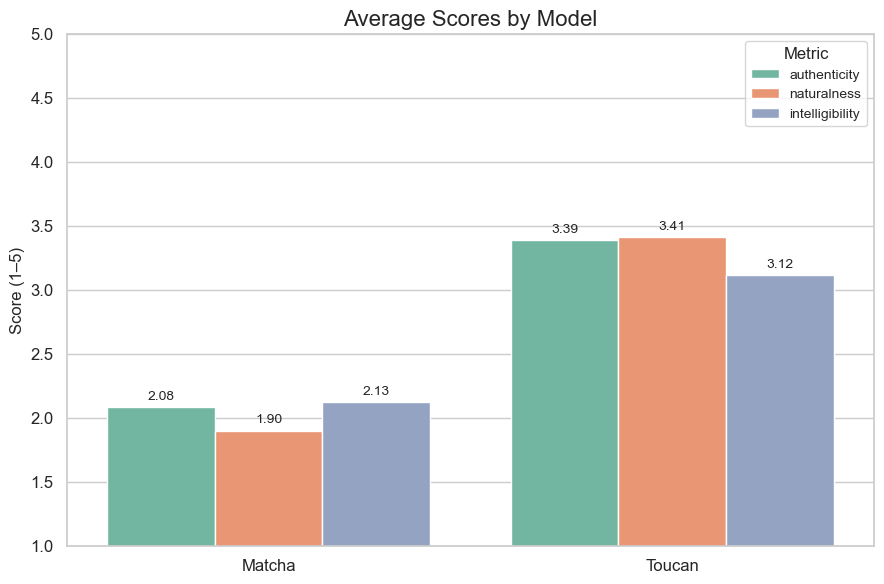

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

# Finds the average scores for each model based on the three metrics (authenticity, naturalness, intelligibility)

sns.set_theme(style="whitegrid", palette="Set2")

merged_df = pd.read_csv("scores_with_models.csv")

average_scores = {
    'authenticity': [merged_df['authenticity_matcha'].mean(), merged_df['authenticity_toucan'].mean()],
    'naturalness': [merged_df['naturalness_matcha'].mean(), merged_df['naturalness_toucan'].mean()],
    'intelligibility': [merged_df['intelligibility_matcha'].mean(), merged_df['intelligibility_toucan'].mean()],
}
scores_df = pd.DataFrame(average_scores, index=['Matcha', 'Toucan'])

scores_long = scores_df.reset_index().melt(id_vars='index', var_name='Metric', value_name='Score')
scores_long.rename(columns={'index': 'Model'}, inplace=True)

plt.figure(figsize=(9, 6))
ax = sns.barplot(data=scores_long, x='Model', y='Score', hue='Metric', errorbar=None)

for container in ax.containers:
    ax.bar_label(container, fmt='%.2f', label_type='edge', padding=3, fontsize=10)

# Labels and layout
plt.title('Average Scores by Model', fontsize=16)
plt.ylabel('Score (1–5)', fontsize=12)
plt.xlabel('')
plt.ylim(1, 5)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.legend(title='Metric', fontsize=10, title_fontsize=12)
plt.tight_layout()
plt.savefig("average_scores_per_model.pdf", format="pdf")
plt.show()


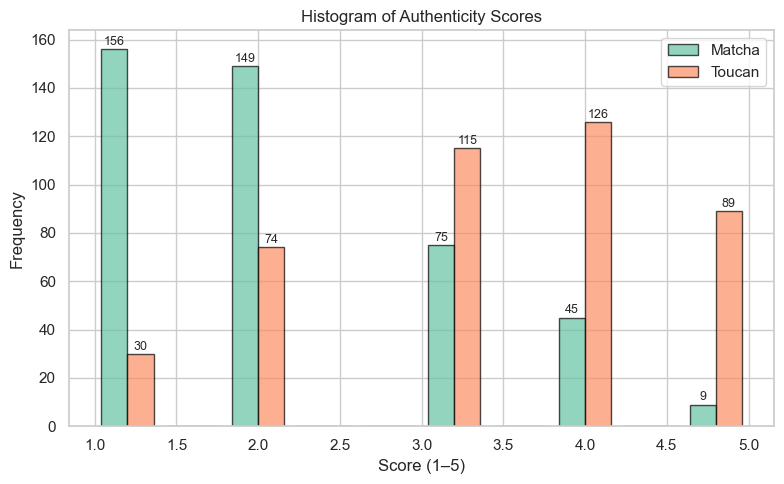

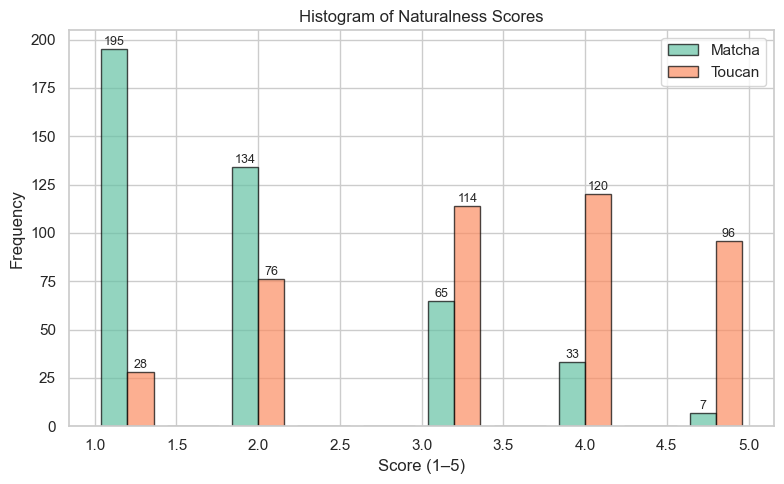

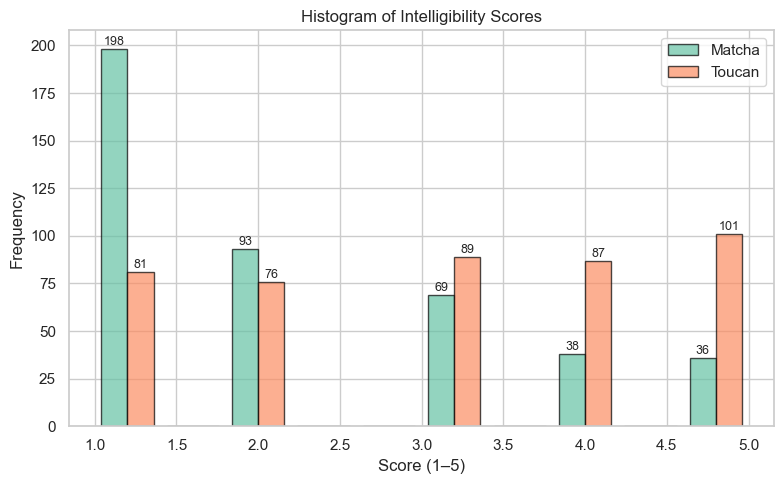

In [ ]:
import matplotlib.pyplot as plt

metrics = ['authenticity', 'naturalness', 'intelligibility']

for metric in metrics:
    plt.figure(figsize=(8, 5))

    matcha_scores = merged_df[f"{metric}_matcha"]
    toucan_scores = merged_df[f"{metric}_toucan"]

    counts, bins, patches = plt.hist(
        [matcha_scores, toucan_scores],
        bins=10,
        label=['Matcha', 'Toucan'],
        alpha=0.7,
        edgecolor='black'
    )

    for i in range(len(patches)):
        for rect in patches[i]:
            height = rect.get_height()
            if height > 0:
                plt.text(
                    rect.get_x() + rect.get_width() / 2,
                    height + 0.5,
                    f"{int(height)}",
                    ha='center',
                    va='bottom',
                    fontsize=9
                )

    plt.title(f'Histogram of {metric.capitalize()} Scores')
    plt.xlabel('Score (1–5)')
    plt.ylabel('Frequency')
    plt.legend()
    plt.tight_layout()
    plt.savefig(f'histogram_{metric}.pdf', format="pdf")
    plt.show()


In [ ]:
participants_df = pd.read_csv("participants.csv")

non_null_end_time_count = participants_df['end_time'].notnull().sum()
print("number of participants:",non_null_end_time_count)

number of participants: 31


/var/folders/yk/m4p39krx101g__80pp5jnt6h0000gn/T/ipykernel_85484/3300360385.py:31: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  g = sns.catplot(
/Users/victorialangoe/anaconda3/lib/python3.11/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


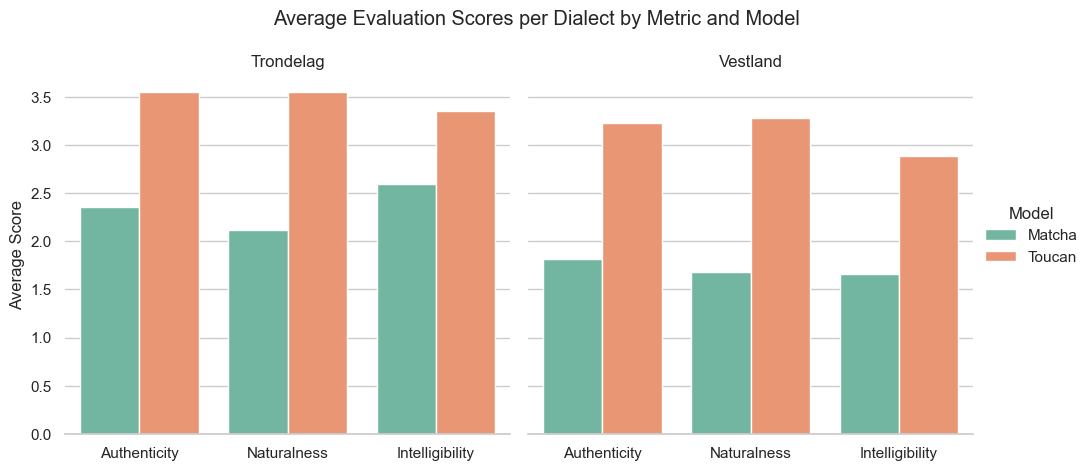

In [ ]:
merged_df = pd.read_csv("scores_with_models.csv")

dialects = merged_df['clip_a_dialect'].unique()
metrics = ['authenticity', 'naturalness', 'intelligibility']
models = ['Matcha', 'Toucan']

plot_data = []

for dialect in dialects:
    for model in models:
        for metric in metrics:
            metric_column = f"{metric}_{model.lower()}"
            filtered_scores = merged_df[
                ((merged_df['clip_a_dialect'] == dialect) & (merged_df['clip_a_model'] == model)) |
                ((merged_df['clip_b_dialect'] == dialect) & (merged_df['clip_b_model'] == model))
            ][metric_column].mean()

            plot_data.append({
                'Dialect': dialect,
                'Model': model,
                'Metric': metric.capitalize(),
                'Average Score': filtered_scores
            })

df_plot = pd.DataFrame(plot_data)

# Plot: Facet by Dialect
sns.set_theme(style="whitegrid")
g = sns.catplot(
    data=df_plot,
    kind="bar",
    x="Metric",
    y="Average Score",
    hue="Model",
    col="Dialect",
    palette="Set2",
    ci=None,
    height=5,
    aspect=1
)

g.figure.subplots_adjust(top=0.85)
g.figure.suptitle("Average Evaluation Scores per Dialect by Metric and Model")
g.set_axis_labels("", "Average Score")
g.set_titles("{col_name}")
g.despine(left=True)

plt.savefig("evaluation_scores_by_dialect.pdf", format="pdf")
plt.show()


In [ ]:
# Create pivot table for easy access
pivot_df = df_plot.pivot_table(
    index=["Dialect", "Metric"],
    columns="Model",
    values="Average Score"
).reset_index()

# --- Percent difference between models (per dialect and metric) ---
model_differences = []
for _, row in pivot_df.iterrows():
    dialect = row['Dialect']
    metric = row['Metric']
    matcha_score = row['Matcha']
    toucan_score = row['Toucan']
    percent_diff = abs(matcha_score - toucan_score) / ((matcha_score + toucan_score) / 2) * 100

    model_differences.append({
        'Dialect': dialect,
        'Metric': metric,
        'Matcha Score': matcha_score,
        'Toucan Score': toucan_score,
        'Percent Difference': round(percent_diff, 2)
    })

model_diff_df = pd.DataFrame(model_differences)
model_diff_df.to_csv("model_differences.csv", index=False)
print("\n Percent Difference Between Models (per dialect & metric):")
print(model_diff_df)

# --- Percent difference between dialects (per model and metric) ---
dialect_differences = []
for metric in metrics:
    for model in models:
        # Filter to get scores
        trondelag_score = df_plot[
            (df_plot["Dialect"] == "Trondelag") &
            (df_plot["Metric"] == metric.capitalize()) &
            (df_plot["Model"] == model)
        ]["Average Score"].values[0]

        vestland_score = df_plot[
            (df_plot["Dialect"] == "Vestland") &
            (df_plot["Metric"] == metric.capitalize()) &
            (df_plot["Model"] == model)
        ]["Average Score"].values[0]

        percent_diff = abs(trondelag_score - vestland_score) / ((trondelag_score + vestland_score) / 2) * 100

        dialect_differences.append({
            'Metric': metric,
            'Model': model,
            'Trondelag Score': trondelag_score,
            'Vestland Score': vestland_score,
            'Percent Difference': round(percent_diff, 2)
        })

dialect_diff_df = pd.DataFrame(dialect_differences)
dialect_diff_df.to_csv("dialect_differences.csv", index=False)
print("\n Percent Difference Between Dialects (per model & metric):")
print(dialect_diff_df)



✅ Percent Difference Between Models (per dialect & metric):
     Dialect           Metric  Matcha Score  Toucan Score  Percent Difference
0  Trondelag     Authenticity      2.354839      3.552995               40.56
1  Trondelag  Intelligibility      2.589862      3.350230               25.60
2  Trondelag      Naturalness      2.119816      3.548387               50.41
3   Vestland     Authenticity      1.811060      3.230415               56.31
4   Vestland  Intelligibility      1.663594      2.884793               53.70
5   Vestland      Naturalness      1.682028      3.281106               64.44

✅ Percent Difference Between Dialects (per model & metric):
            Metric   Model  Trondelag Score  Vestland Score  \
0     authenticity  Matcha         2.354839        1.811060   
1     authenticity  Toucan         3.552995        3.230415   
2      naturalness  Matcha         2.119816        1.682028   
3      naturalness  Toucan         3.548387        3.281106   
4  intelligibilit

In [ ]:
# Average scores per model and metric across both dialects
avg_scores_per_model = df_plot.groupby(['Model', 'Metric'])['Average Score'].mean().reset_index()

# Find the worst (lowest) scoring metric for each model
worst_per_model = avg_scores_per_model.loc[avg_scores_per_model.groupby('Model')['Average Score'].idxmin()]

print("\n🔻 Metric with lowest average score per model:")
print(worst_per_model)



🔻 Metric with lowest average score per model:
    Model           Metric  Average Score
2  Matcha      Naturalness       1.900922
4  Toucan  Intelligibility       3.117512


In [ ]:
# Average score per metric across all models and dialects
avg_scores_overall = df_plot.groupby('Metric')['Average Score'].mean().reset_index()

# the metric with the lowest overall average score
worst_metric = avg_scores_overall.loc[avg_scores_overall['Average Score'].idxmin()]

print("\n📉 Overall worst-performing metric (averaged across all models and dialects):")
print(worst_metric)


📉 Overall worst-performing metric (averaged across all models and dialects):
Metric           Intelligibility
Average Score            2.62212
Name: 1, dtype: object


In [ ]:
average_model_improvement = model_diff_df["Percent Difference"].mean().round(2)
print(f"\n📈 On average, Toucan scores {average_model_improvement}% higher than Matcha across all metrics and dialects.")


📈 On average, Toucan scores 48.5% higher than Matcha across all metrics and dialects.


In [ ]:
from scipy.stats import ttest_rel

def perform_ttest(df, metric, alpha=0.05):
    """
    Perform a pairwise t-test for a specific metric.

    Parameters:
        df (DataFrame): The DataFrame containing the data.
        metric (str): The metric name (e.g., 'authenticity', 'naturalness', 'intelligibility').
        alpha (float): The significance level (default 0.05).

    Returns:
        None: Prints the t-test results.
    """
    matcha_col = f"{metric}_matcha"
    toucan_col = f"{metric}_toucan"

    t_stat, p_value = ttest_rel(df[matcha_col], df[toucan_col])

    t_stat = round(t_stat, 2)
    p_value = round(p_value, 2)

    print(f"T-statistic ({metric.capitalize()}): {t_stat}")
    print(f"P-value ({metric.capitalize()}): {p_value}")

    if p_value < alpha:
        print(f"There is a significant difference in {metric} scores between Matcha and Toucan.")
    else:
        print(f"No significant difference in {metric} scores between Matcha and Toucan.")

metrics = ['authenticity', 'naturalness', 'intelligibility']

for metric in metrics:
    perform_ttest(merged_df, metric, alpha=0.05)


T-statistic (Authenticity): -19.64
P-value (Authenticity): 0.0
There is a significant difference in authenticity scores between Matcha and Toucan.
T-statistic (Naturalness): -20.64
P-value (Naturalness): 0.0
There is a significant difference in naturalness scores between Matcha and Toucan.
T-statistic (Intelligibility): -13.51
P-value (Intelligibility): 0.0
There is a significant difference in intelligibility scores between Matcha and Toucan.


In [ ]:
from scipy.stats import wilcoxon

def perform_wilcoxon(df, metric, alpha=0.05):
    """
    Perform a Wilcoxon signed-rank test for a specific metric.

    Parameters:
        df (DataFrame): The DataFrame containing the data.
        metric (str): The metric name (e.g., 'authenticity', 'naturalness', 'intelligibility').
        alpha (float): The significance level (default 0.05).

    Returns:
        None: Prints the test results.
    """
    matcha_col = f"{metric}_matcha"
    toucan_col = f"{metric}_toucan"

    w_stat, p_value = wilcoxon(df[matcha_col], df[toucan_col])

    w_stat = round(w_stat, 2)
    p_value = round(p_value, 4)

    print(f"Wilcoxon Statistic ({metric.capitalize()}): {w_stat}")
    print(f"P-value ({metric.capitalize()}): {p_value}")


    if p_value < alpha:
        print(f"There is a significant difference in {metric} scores between Matcha and Toucan.")
    else:
        print(f"No significant difference in {metric} scores between Matcha and Toucan.")

# Example usage
metrics = ['authenticity', 'naturalness', 'intelligibility']

for metric in metrics:
    perform_wilcoxon(merged_df, metric, alpha=0.05)


Wilcoxon Statistic (Authenticity): 4471.0
P-value (Authenticity): 0.0
There is a significant difference in authenticity scores between Matcha and Toucan.
Wilcoxon Statistic (Naturalness): 4221.0
P-value (Naturalness): 0.0
There is a significant difference in naturalness scores between Matcha and Toucan.
Wilcoxon Statistic (Intelligibility): 6098.0
P-value (Intelligibility): 0.0
There is a significant difference in intelligibility scores between Matcha and Toucan.


In [ ]:
from scipy.stats import shapiro

metrics = ["authenticity", "naturalness", "intelligibility"]

print("Shapiro-Wilk Normality Test for Differences Between Matcha and Toucan:\n")

for metric in metrics:
    # Compute the difference between Matcha and Toucan scores
    differences = merged_df[f"{metric}_matcha"] - merged_df[f"{metric}_toucan"]
    
    # Apply Shapiro-Wilk test
    stat, p_value = shapiro(differences)
    
    # Print results
    print(f"🧪 {metric.capitalize()}:")
    print(f"   Shapiro-Wilk Statistic: {stat:.4f}")
    print(f"   P-value: {p_value:.4f}")
    if p_value > 0.05:
        print("The differences follow a normal distribution.\n")
    else:
        print("The differences do not follow a normal distribution.\n")


📊 Shapiro-Wilk Normality Test for Differences Between Matcha and Toucan:

🧪 Authenticity:
   Shapiro-Wilk Statistic: 0.9487
   P-value: 0.0000
   ❌ The differences do not follow a normal distribution.

🧪 Naturalness:
   Shapiro-Wilk Statistic: 0.9482
   P-value: 0.0000
   ❌ The differences do not follow a normal distribution.

🧪 Intelligibility:
   Shapiro-Wilk Statistic: 0.9477
   P-value: 0.0000
   ❌ The differences do not follow a normal distribution.



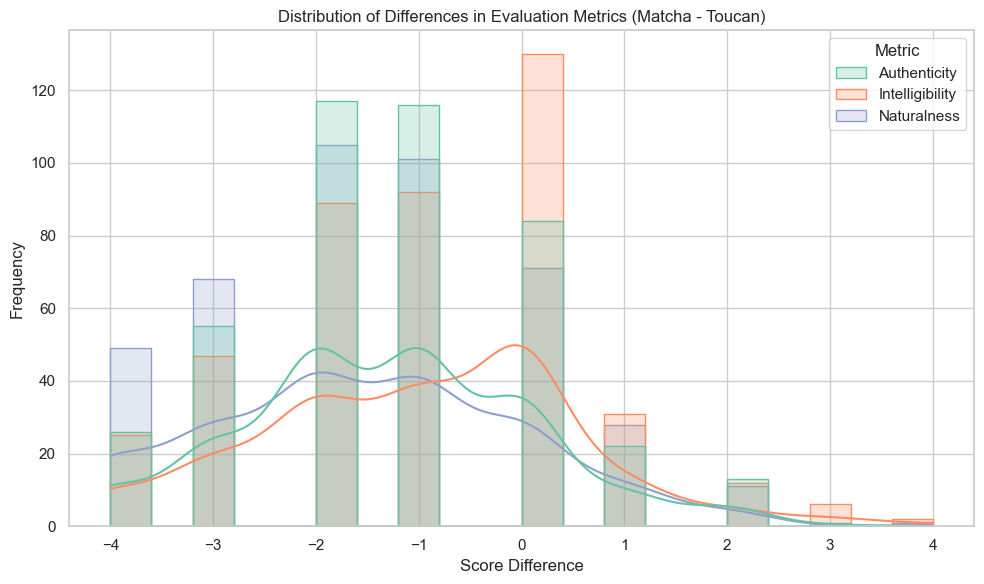

In [ ]:
sns.set_theme(style="whitegrid")

auth_diff = merged_df["authenticity_matcha"] - merged_df["authenticity_toucan"]
intell_diff = merged_df["intelligibility_matcha"] - merged_df["intelligibility_toucan"]
nat_diff = merged_df["naturalness_matcha"] - merged_df["naturalness_toucan"]

df = pd.DataFrame({
    "Difference": pd.concat([auth_diff, intell_diff, nat_diff], ignore_index=True),
    "Metric": (
        ["Authenticity"] * len(auth_diff)
        + ["Intelligibility"] * len(intell_diff)
        + ["Naturalness"] * len(nat_diff)
    )
})

# Plot with different colors per metric
plt.figure(figsize=(10, 6))
sns.histplot(
    data=df,
    x="Difference",
    hue="Metric",
    element="step",
    stat="count",
    common_norm=False,
    bins=20,
    kde=True,
    palette="Set2"
)

plt.title("Distribution of Differences in Evaluation Metrics (Matcha - Toucan)")
plt.xlabel("Score Difference")
plt.ylabel("Frequency")
plt.grid(True)
plt.tight_layout()
plt.savefig("combined_distribution_plot.pdf", format="pdf")
plt.show()

In [ ]:
# Total number of participants
total_rows = len(participants_df)
print(f"Total number of participants: {total_rows}")

# Filter participants who finished
filtered_participants_df = participants_df[participants_df['end_time'].notnull()].copy()

# Convert to datetime after filtering
filtered_participants_df['created_at'] = pd.to_datetime(filtered_participants_df['created_at'])
filtered_participants_df['end_time'] = pd.to_datetime(filtered_participants_df['end_time'])

# Calculate time taken in seconds
filtered_participants_df['time_taken'] = (filtered_participants_df['end_time'] - filtered_participants_df['created_at']).dt.total_seconds()

# Average time taken in minutes
average_time_minutes = filtered_participants_df['time_taken'].mean() / 60
print(f"Average time taken by participants: {average_time_minutes:.2f} minutes")

# Distributions
gender_counts = filtered_participants_df['gender'].value_counts()
gender_percentages = (gender_counts / len(filtered_participants_df)) * 100

age_counts = filtered_participants_df['age'].value_counts()
age_percentages = (age_counts / len(filtered_participants_df)) * 100

linguistics_counts = filtered_participants_df['linguistics'].value_counts()
linguistics_percentages = (linguistics_counts / len(filtered_participants_df)) * 100

hearing_impairment_counts = filtered_participants_df['hearing_impairment'].value_counts()
hearing_impairment_percentages = (hearing_impairment_counts / len(filtered_participants_df)) * 100

# Summary dictionary
summary = {
    "Gender Counts": gender_counts,
    "Gender Percentages": gender_percentages,
    "Age Counts": age_counts,
    "Age Percentages": age_percentages,
    "Linguistics Counts": linguistics_counts,
    "Linguistics Percentages": linguistics_percentages,
    "Hearing Impairment Counts": hearing_impairment_counts,
    "Hearing Impairment Percentages": hearing_impairment_percentages,
}

print("\nSummary of participant demographics and time taken:")
for key, value in summary.items():
    print(f"\n{key}:\n{value}")


Total number of participants: 50
Average time taken by participants: 16.14 minutes

📊 Summary of participant demographics and time taken:

Gender Counts:
gender
Kvinne    16
Mann      15
Name: count, dtype: int64

Gender Percentages:
gender
Kvinne    51.612903
Mann      48.387097
Name: count, dtype: float64

Age Counts:
age
18-29            22
30-39             4
50 og oppover     3
40-49             2
Name: count, dtype: int64

Age Percentages:
age
18-29            70.967742
30-39            12.903226
50 og oppover     9.677419
40-49             6.451613
Name: count, dtype: float64

Linguistics Counts:
linguistics
Nei    29
Ja      2
Name: count, dtype: int64

Linguistics Percentages:
linguistics
Nei    93.548387
Ja      6.451613
Name: count, dtype: float64

Hearing Impairment Counts:
hearing_impairment
False    31
Name: count, dtype: int64

Hearing Impairment Percentages:
hearing_impairment
False    100.0
Name: count, dtype: float64


In [ ]:
participants_df = pd.read_csv("participants.csv")

completed_df = participants_df[participants_df['end_time'].notnull()].copy()

# Convert timestamps
completed_df['created_at'] = pd.to_datetime(completed_df['created_at'])
completed_df['end_time'] = pd.to_datetime(completed_df['end_time'])

completed_df['response_time_minutes'] = (
    (completed_df['end_time'] - completed_df['created_at']).dt.total_seconds() / 60
)

mean_time = completed_df['response_time_minutes'].mean()
min_time = completed_df['response_time_minutes'].min()
max_time = completed_df['response_time_minutes'].max()
std_time = completed_df['response_time_minutes'].std()

print("📊 Survey Completion and Response Time Statistics:")
print(f"Average response time: {mean_time:.2f} minutes")
print(f"Minimum response time: {min_time:.2f} minutes")
print(f"Maximum response time: {max_time:.2f} minutes")
print(f"Standard deviation: {std_time:.2f} minutes")

# Device usage counts
device_counts = completed_df['is_mobile'].value_counts()
mobile_count = device_counts.get(True, 0)
desktop_count = device_counts.get(False, 0)
total_devices = mobile_count + desktop_count

mobile_percentage = (mobile_count / total_devices) * 100
desktop_percentage = (desktop_count / total_devices) * 100

print("\n Device Usage:")
print(f"Mobile: {mobile_count} ({mobile_percentage:.2f}%)")
print(f"Desktop: {desktop_count} ({desktop_percentage:.2f}%)")

📊 Survey Completion and Response Time Statistics:
Average response time: 16.14 minutes
Minimum response time: 8.79 minutes
Maximum response time: 30.72 minutes
Standard deviation: 5.76 minutes

💻📱 Device Usage:
Mobile: 13 (41.94%)
Desktop: 18 (58.06%)
